# WeatherPy
----
### Background / Issues
* Goal:  understand how the weather changes as one approaches the equator
* Basic approach:  Use openweathermap API to sample weather in cities using the citipy dataset and examine the effects of latitude
* Issues:  "City weather" is quite different from weather in general.  Cities are on land, tend to be near large bodies of water, and tend not to be at high elevation, in polar regions, on rugged terrain, in deserts, etc.  So, the more specific question that we will answer is "how does the weather in cities change as one approaches the equator?"
* Please see the "README" deisgn doc for more detailed discussion and instructions for use.


### Analysis
* As expected, the weather becomes significantly warmer as one approaches the equator (0 Deg. Latitude). More interestingly, however, is the fact that the southern hemisphere tends to be warmer this time of year than the northern hemisphere. This may be due to the tilt of the earth.
* There is no strong relationship between latitude and cloudiness. However, it is interesting to see that a strong band of cities sits at 0, 80, and 100% cloudiness.
* There is no strong relationship between latitude and wind speed. However, in northern hemispheres there is a flurry of cities with over 20 mph of wind.

---

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from datetime import datetime
import openweathermapy.core as owm
import pprint as pp
import inspect
from haversine import haversine
# Import API key
from config import api_key

# Incorporated haversine library to calculate distances
# from haversine import haversine

# Input File (CSV)
input_data_file = 'citipy/worldcities.csv'

# Output File (CSV)
output_data_file = 'output_data/cities.csv'

# Output log File (TXT)
output_log = 'output_data/log.txt'

### Code Parameters 

In [2]:
# Constants
# lat_radius will control the size of the search radius (in distance equal to deg lat, 
# which means 1.0 = 111 km, 2.0 = 222 km, etc.  Smaller = longer time to build city list
# but larger = less perfect sampling of population.  Note that city locations are not
# meaningful at less than 10 km resolution, that is, lat_radius < 0.1.  
lat_radius = 1.0
# Batch and sample size control how many cities per query list we build.  The notebook
# will build a list of cities of batch_size, then query one at a time until it reaches
# data_size successful weather reports.  It if fails to reach data_size with one batch,
# it will continue to query, until max_batches.  Batch_size should not need to exceed
# three times data_size for success in one batch, which is recommended.  A large value of
# max_batches could lead to account deactivation on OpenWeatherMap.
batch_size = 12
data_size = 3
max_batches = 2

### Prepare City Data
By importing directly from the csv, we lose the kd-tree structure from citipy, but we gain the ability to
do the appropriate math.

In [3]:
# Read the DataFrame and sort it by latitude then longitude
city_df = pd.read_csv(input_data_file).sort_values(by=['Latitude','Longitude']).reset_index(drop=True)
city_df.head()
# Store max and min of latitude for later.  

,Country,City,Latitude,Longitude
0,ar,ushuaia,-54.800000,-68.300000
1,cl,punta arenas,-53.150000,-70.916667
2,ar,rio gallegos,-51.622613,-69.218127
3,nz,bluff,-46.600000,168.333333
4,nz,invercargill,-46.400000,168.350000


## Generate Cities List

In [4]:
def getcities(batch=batch_size, radius = lat_radius):
    '''Returns a list of city names with length equal to batch.  In practice, this means transforming
    the latitude distribution by an inverse cosine to give appropriately gerater probability to points
    along the equator and vanishingly small probability of points approaching the poles. Once a point
    is selected, a search for cities using the global city_df is made, and the nearest city having
    a distance less than 'radius' (in latitude degrees, 1 deg = 111.13 km) is selected.'''
# List for holding city names and search count.  For safety, we will terminate at a fixed number of searches.
    cities = []
    searches = 0
    max_searches = 100
# Loop through until we get the required number of successes
    while len(cities) <  batch and searches <= max_searches:
        city_name = ''
        max_dist = 111.13 * radius  #Converts latitude degrees to km, based on average radius of Earth
        # Choose a random point on Earth's surface
        lat = 180.0 / 3.1416 *  np.arccos(2 * np.random.rand() -1) - 90
        lng = 360.0 * np.random.rand() - 180.0
        # The search is a two-part filter.  The first is a direct filter of any place with the wrong lats 
        # We do not filter on lngs because the modular arithmetic and nonlinearity make it quite complex.  
        # Here we use df.iat for fast look-up, with only numbers for indices (city name = 1, lat = 2, lng = 3)
        for ix in range(len(city_df)):
            if (abs(city_df.iat[ix,2] - lat) < radius):
                dist = haversine((lat, lng),(city_df.iat[ix,2],city_df.iat[ix,3]))
            # The second part of the search is a simple minimum finder initialized to the maximum permitted value.
                if dist < max_dist and city_df.iat[ix,1] not in cities:
                    city_name = city_df.iat[ix,1]
                    max_dist = dist
        # Append the nearest city if we found one
        if city_name:
            cities.append(city_name)
        searches += 1
        if searches > max_searches:
            print('Not finding cities efficiently.  Please increase lat_radius')
    print(f'{len(cities)} found.')
    return cities

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [29]:
# Build the city list
citylist = getcities()
# Create settings for API call
settings = {'units':'imperial','appid':api_key}
# Set up objects to hold results and count of attempts and successes
attempt_num = 0
citycount = 0
cityfound = []
countryfound = []
tempfound = []
humidfound = []
windfound = []
cloudfound = []
latfound = []
lngfound = []
whenfound = []

# Get the data 
with open(output_log,'w') as f:
    while citycount < data_size and attempt_num < len(citylist):
        attempt_num += 1
        city = citylist[attempt_num]
        # Reset temp holders
        tmpcity, tmpcountry, tmptemp, tmphumid, tmpwind, tmpclouds, tmplat, tmplng = '','','','','','','',''
        # Log request
        print('Requesting weather for ' + city + '...')
        reqtime = datetime.now()
        f.write('Request city: ' + city + ' at ' + reqtime.strftime('%m/%d/%Y, %H:%M:%S') + '\n')
        # Make request from openweathermap
        try:
            weather = owm.get_current(city, **settings)
            # Store results in temporary objects for checking, enforce types for later
            tmpcity = weather['name']
            tmpcountry = weather['sys']['country']
            tmptemp = float(weather['main']['temp'])
            tmphumid = float(weather['main']['humidity'])
            tmpwind = float(weather['wind']['speed'])
            tmpclouds = float(weather['clouds']['all'])
            tmplat = float(weather['coord']['lat'])
            tmplng = float(weather['coord']['lon'])
            # Log data 
            reqtime = datetime.now()
            f.write('Response at ' + reqtime.strftime('%m/%d/%Y, %H:%M:%S') + '\n')
            f.write('City: ' + tmpcity + ' Country: ' + tmpcountry)
            f.write(' Temp: ' + str(tmptemp) + ' Humidity: ' + str(tmphumid))       
            f.write(' Wind: ' + str(tmpwind) + ' Cloud cover: ' + str(tmpclouds))    
            f.write(' Lat: ' + str(tmplat) + ' Lng: ' + str(tmplng) + '\n')
        except urllib.HTTPError:
            print('HTTP Error')
            f.write('HTTP Request Failed\n')
        except KeyError:
            print('Weather data not found.')
            f.write('Weather data not found.\n')
        if all ((tmpcity != '', tmpcountry !='', tmptemp > -99, tmphumid >=0,\
                    tmpwind >=0, tmpclouds >=0, tmplat >=-90, tmplng >=-180)):
            print('Succes. City: '+ tmpcity + ' found. Raw data in file')
            f.write('Success.  Appending data.\n')
            # In this case, increment success counter and append data to lists
            citycount += 1
            cityfound.append(tmpcity)
            countryfound.append(tmpcountry)
            tempfound.append(tmptemp)
            humidfound.append(tmphumid)
            windfound.append(tmpwind)
            cloudfound.append(tmpclouds)
            latfound.append(tmplat)
            lngfound.append(tmplng)
            whenfound.append(reqtime)
        else:
            print('There was a problem with ' + tmpcity + '.  Raw data in file')
            f.write('Data does not meet criteria and will not be used.\n')

12 found.
Requesting weather for nagpur...
Succes. City: Nagpur found. Raw data in file
Requesting weather for miandrivazo...
Succes. City: Miandrivazo found. Raw data in file
Requesting weather for shima...
Succes. City: Shima found. Raw data in file


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [42]:
# Generate DataFrame with the results
weather_df = pd.DataFrame({'City':cityfound,'Country':countryfound,'Latitude':latfound,
                          'Longitude':lngfound,'Time':whenfound,'Temperature (deg F)':tempfound,
                          'Humidity (%)':humidfound,'Wind Speed (mph)':windfound,'Cloud Cover (%)':cloudfound})
weather_df.to_csv(output_data_file)
weather_df

,City,Country,Latitude,Longitude,Time,Temperature (deg F),Humidity (%),Wind Speed (mph),Cloud Cover (%)
0,Nagpur,IN,21.15,79.08,2019-03-28 14:15:00.984889,78.80,31.0,3.36,0.0
1,Miandrivazo,MG,-19.53,45.46,2019-03-28 14:15:01.560047,71.36,87.0,3.38,76.0
2,Shima,JP,34.34,136.82,2019-03-28 14:15:02.593915,46.40,49.0,13.87,75.0


### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

#### Latitude vs. Temperature Plot

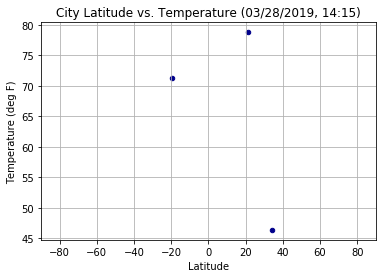

In [43]:
weather_df.plot(kind='scatter',x='Latitude',y='Temperature (deg F)',
                title='City Latitude vs. Temperature (%s)' % weather_df.loc[0,'Time'].strftime('%m/%d/%Y, %H:%M'),
                grid=True,xlim=(-90,90),color='darkblue')
plt.savefig('output_data/lat_v_temp.png')

#### Latitude vs. Humidity Plot

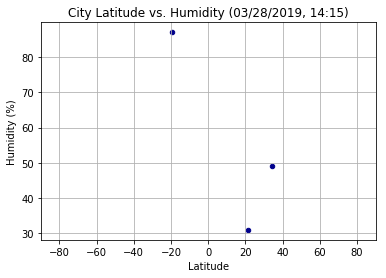

In [44]:
weather_df.plot(kind='scatter',x='Latitude',y='Humidity (%)',
                title='City Latitude vs. Humidity (%s)' % weather_df.loc[0,'Time'].strftime('%m/%d/%Y, %H:%M'),
                grid=True,xlim=(-90,90),color='darkblue')
plt.savefig('output_data/lat_v_humid.png')

#### Latitude vs. Cloudiness Plot

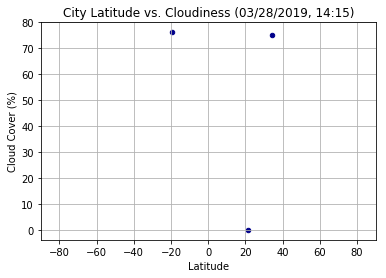

In [45]:
weather_df.plot(kind='scatter',x='Latitude',y='Cloud Cover (%)',
                title='City Latitude vs. Cloudiness (%s)' % weather_df.loc[0,'Time'].strftime('%m/%d/%Y, %H:%M'),
                grid=True,xlim=(-90,90),color='darkblue')
plt.savefig('output_data/lat_v_cloud.png')

#### Latitude vs. Wind Speed Plot

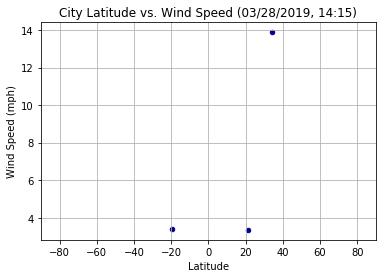

In [46]:
weather_df.plot(kind='scatter',x='Latitude',y='Wind Speed (mph)',
                title='City Latitude vs. Wind Speed (%s)' % weather_df.loc[0,'Time'].strftime('%m/%d/%Y, %H:%M'),
                grid=True,xlim=(-90,90),color='darkblue')
plt.savefig('output_data/lat_v_wind.png')

1544.7596947396298